In [1]:
import optuna

# Torch
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset

from torch_geometric.data import DataLoader, HeteroData
from torch_geometric.loader import DataLoader
from torch_geometric_temporal.nn.recurrent import GConvGRU

from torch_geometric.nn import SAGEConv, DenseSAGEConv, GATConv, HeteroConv, Linear, GATv2Conv, TransformerConv
from torch_geometric.nn import aggr

# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Scikit-learn
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc, brier_score_loss

# Misc
import os, sys
import time
from math import ceil
import random
from IPython.display import clear_output
from termcolor import colored

# CS2
sys.path.append(os.path.abspath('../../package'))
from CS2.visualize import HeteroGNNRoundAnalyzer

# Torch and CUDA options
torch.manual_seed(42)
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Path constants
PATH_TEMP_GRAPH_DATA = '../../data/matches-processed/cs2/temporal-hetero-graph/'
PATH_MODELS = '../../model/tgn/'
BATCH_SIZE = 100

C:\Users\szmid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Static round probabilities

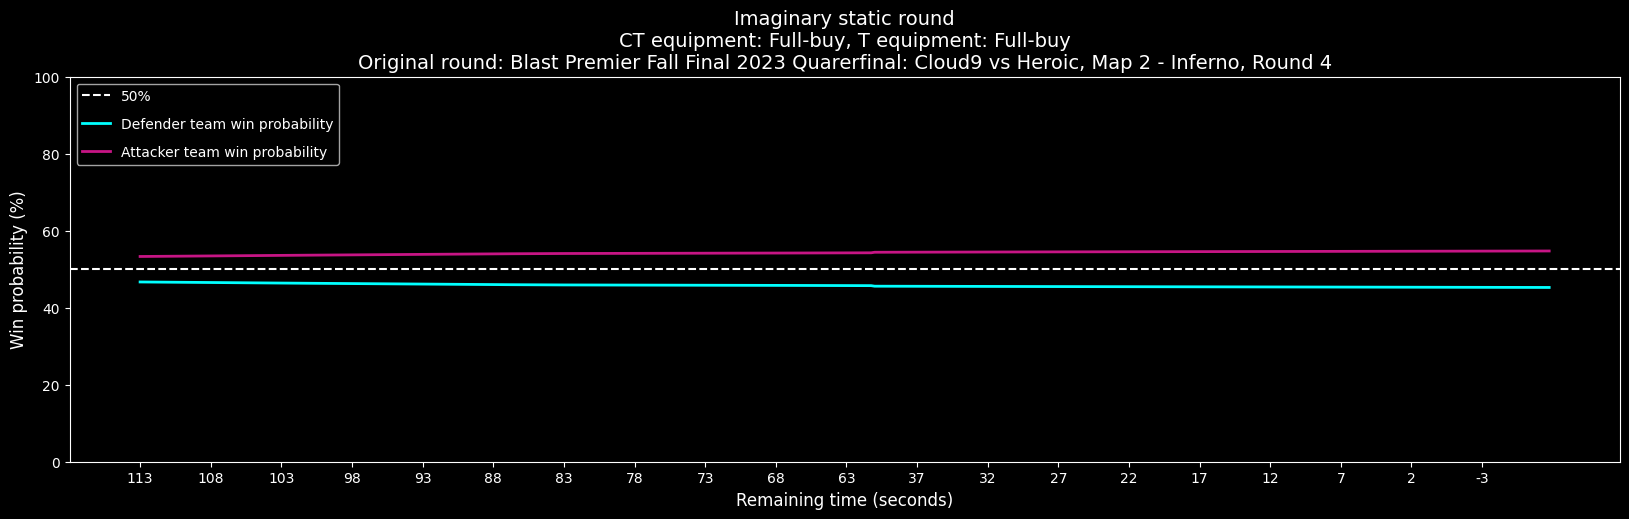

In [41]:
# Read the model class txt file
model_folder = '241020_2/'
model_class_code = ''
with open(PATH_MODELS + model_folder + 'gnn_code.txt', 'r') as f:
    model_class_code = f.read()

# Run the model class code
exec(model_class_code)

# Model
model = torch.load(PATH_MODELS + model_folder + 'epoch_2.pt', weights_only=False)

# Static Data
# Round 1 - Pistol economy (Ts won)
# Round 2 - CT: Eco, T: Semi-full buy (Ts won)
# Round 4 - CT: Full buy, T: Full buy (CTs won)
data  = torch.load(PATH_TEMP_GRAPH_DATA + 'static_rounds.pt', weights_only=False)

# Analyze round
analyzer = HeteroGNNRoundAnalyzer()

# Round 1
# analyzer.analyze_round(data, model, 1, plt_title='Imaginary static round\nCT equipment: Pistol, T equipment: Pistol\nOriginal round: Blast Premier Fall Final 2023 Quarerfinal: Cloud9 vs Heroic, Map 2 - Inferno, Round 1')

# Round 2
# analyzer.analyze_round(data, model, 2, plt_title='Imaginary static round\nCT equipment: Eco (Lost pistol), T equipment: Semi-full buy (Won pistol)\nOriginal round: Blast Premier Fall Final 2023 Quarerfinal: Cloud9 vs Heroic, Map 2 - Inferno, Round 2')

# Round 4
analyzer.analyze_round(data, model, 4, plt_title='Imaginary static round\nCT equipment: Full-buy, T equipment: Full-buy\nOriginal round: Blast Premier Fall Final 2023 Quarerfinal: Cloud9 vs Heroic, Map 2 - Inferno, Round 4')

#### Workflow code

In [2]:
# Read the model class txt file
model_folder = '241020_2/'
model_class_code = ''
with open(PATH_MODELS + model_folder + 'gnn_code.txt', 'r') as f:
    model_class_code = f.read()

# Run the model class code
exec(model_class_code)

# Model
model = torch.load(PATH_MODELS + model_folder + 'epoch_2.pt', weights_only=False)

# Data
data  = torch.load(PATH_TEMP_GRAPH_DATA + '100000.pt', weights_only=False)

In [12]:
rounds = []

for graph in data:
    print(graph[0].y['round'])

0.041666668
0.041666668
0.041666668
0.041666668
0.041666668
0.041666668
0.041666668
0.041666668
0.041666668
0.041666668
0.041666668
0.041666668
0.041666668
0.041666668
0.041666668
0.041666668
0.041666668
0.041666668
0.041666668
0.041666668
0.041666668
0.041666668
0.041666668
0.041666668
0.041666668
0.041666668
0.041666668
0.041666668
0.041666668
0.041666668
0.041666668
0.041666668
0.041666668
0.041666668
0.041666668
0.041666668
0.041666668
0.041666668
0.041666668
0.083333336
0.083333336
0.083333336
0.083333336
0.083333336
0.083333336
0.083333336
0.083333336
0.083333336
0.083333336
0.083333336
0.083333336
0.083333336
0.083333336
0.083333336
0.083333336
0.083333336
0.083333336
0.083333336
0.083333336
0.083333336
0.083333336
0.083333336
0.083333336
0.083333336
0.083333336
0.083333336
0.083333336
0.083333336
0.083333336
0.083333336
0.083333336
0.083333336
0.083333336
0.083333336
0.083333336
0.125
0.125
0.125
0.125
0.125
0.125
0.125
0.125
0.125
0.125
0.125
0.125
0.125
0.125
0.125
0.125
0.12

In [27]:
fourth_round = []

for dyn_graph in data:

    if dyn_graph[0].y['round'] == np.float32(0.083333336):
        fourth_round.append(dyn_graph)

start_time = 1
filtered_fourth_round = []

for dyn_graph in fourth_round:
    if (dyn_graph[-1].y['remaining_time'] < start_time) or \
    (dyn_graph[-1].y['remaining_time'] > start_time and dyn_graph[-1].y['remaining_time'] < 0.9):
        start_time = dyn_graph[-1].y['remaining_time'] 
        filtered_fourth_round.append(dyn_graph)
    else:
        break

len(filtered_fourth_round)

18

In [28]:
first_frame_map = filtered_fourth_round[0][0]['map'].x
first_frame_player = filtered_fourth_round[0][0]['player'].x
first_frame_player[:, 5:8] = torch.zeros([10, 3])

first_frame_player_edges = filtered_fourth_round[0][0][('player', 'closest_to', 'map')].edge_index

first_frame_y = filtered_fourth_round[0][0].y

static_round = []

for dyn_graph in filtered_fourth_round:
    
    static_dyn_graph = []
    
    for graph in dyn_graph:

        static_graph = HeteroData()
        static_graph['map'].x = first_frame_map
        static_graph['player'].x = first_frame_player
        static_graph[('player', 'is', 'player')].edge_index = graph[('player', 'is', 'player')].edge_index
        static_graph[('player', 'closest_to', 'map')].edge_index = first_frame_player_edges
        static_graph[('map', 'connected_to', 'map')].edge_index = graph[('map', 'connected_to', 'map')].edge_index

        remaining_time = graph.y['remaining_time']
        time = graph.y['time']
        freeze_end = graph.y['freeze_end']
        end = graph.y['end']

        static_graph.y = {
            'tick': first_frame_y['tick'],
            'round': first_frame_y['round'],
            'time': time,
            'remaining_time': remaining_time,
            'freeze_end': freeze_end,
            'end': end,
            'CT_score': first_frame_y['CT_score'],
            'T_score': first_frame_y['T_score'],
            'CT_alive_num': first_frame_y['CT_alive_num'],
            'T_alive_num': first_frame_y['T_alive_num'],
            'CT_total_hp': first_frame_y['CT_total_hp'],
            'T_total_hp': first_frame_y['T_total_hp'],
            'CT_equipment_value': first_frame_y['CT_equipment_value'],
            'T_equipment_value': first_frame_y['T_equipment_value'],
            'CT_losing_streak': first_frame_y['CT_losing_streak'],
            'T_losing_streak': first_frame_y['T_losing_streak'],
            'is_bomb_dropped': first_frame_y['is_bomb_dropped'],
            'is_bomb_being_planted': first_frame_y['is_bomb_being_planted'],
            'is_bomb_being_defused': first_frame_y['is_bomb_being_defused'],
            'is_bomb_defused': first_frame_y['is_bomb_defused'],
            'is_bomb_planted_at_A_site': first_frame_y['is_bomb_planted_at_A_site'],
            'is_bomb_planted_at_B_site': first_frame_y['is_bomb_planted_at_B_site'],
            'bomb_X': first_frame_y['bomb_X'],
            'bomb_Y': first_frame_y['bomb_Y'],
            'bomb_Z': first_frame_y['bomb_Z'],
            'bomb_mx_pos1': first_frame_y['bomb_mx_pos1'],
            'bomb_mx_pos2': first_frame_y['bomb_mx_pos2'],
            'bomb_mx_pos3': first_frame_y['bomb_mx_pos3'],
            'bomb_mx_pos4': first_frame_y['bomb_mx_pos4'],
            'bomb_mx_pos5': first_frame_y['bomb_mx_pos5'],
            'bomb_mx_pos6': first_frame_y['bomb_mx_pos6'],
            'bomb_mx_pos7': first_frame_y['bomb_mx_pos7'],
            'bomb_mx_pos8': first_frame_y['bomb_mx_pos8'],
            'bomb_mx_pos9': first_frame_y['bomb_mx_pos9'],
            'CT_wins': first_frame_y['CT_wins'],
        }

        static_dyn_graph.append(static_graph)

    static_round.append(static_dyn_graph)

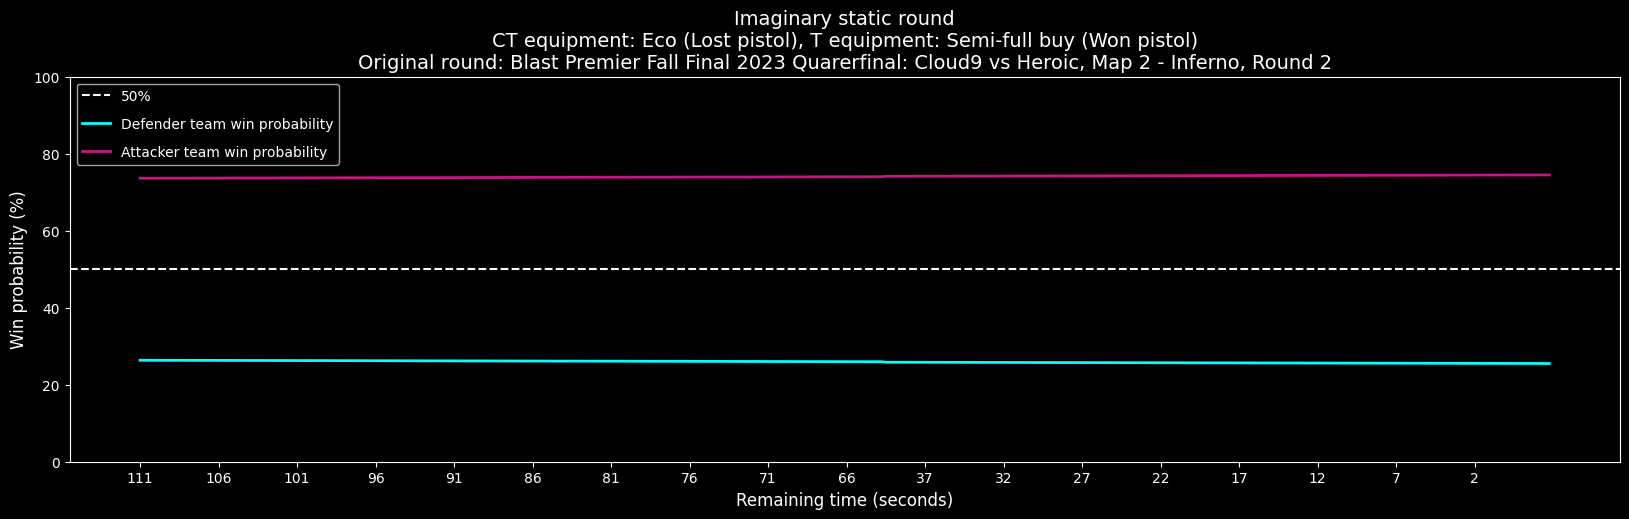

In [29]:
analyzer = HeteroGNNRoundAnalyzer()
analyzer.analyze_round(static_round, model, 2, plt_title='Imaginary static round\nCT equipment: Eco (Lost pistol), T equipment: Semi-full buy (Won pistol)\nOriginal round: Blast Premier Fall Final 2023 Quarerfinal: Cloud9 vs Heroic, Map 2 - Inferno, Round 2')

In [21]:
static_round_1 = static_round

In [30]:
static_round_2 = static_round

In [10]:
static_round_4 = static_round

In [31]:
static_rounds = [static_round_1, static_round_2, static_round_4]
torch.save(static_rounds, PATH_TEMP_GRAPH_DATA + 'static_rounds.pt')